# 1. Importing the packages

This notebook is used to create the average level of insulation per postalcode. This dataset is used to merge on the neighborhoods dataframe to allow for the inclusion of insulation statistics in the model.

In [10]:
# Importing python packages

import numpy as np 
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

from pyxlsb import open_workbook

# import seaborn as sns
import matplotlib. pyplot as plt # for plotting graphs
import matplotlib.mlab as mlab # 
import matplotlib
plt.style.use('ggplot') # basic, but functional, plotstyle,
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

# 2. Reading the data

Website sourcefile: https://www.rvo.nl/onderwerpen/duurzaam-ondernemen/gebouwen/hulpmiddelen-tools-en-inspiratie-gebouwen/ep-online

Importing the xlsb file format of this dataset is not as straightforward as using the pandas read_excel function. We therefore need the pyxlsb package to read the file. Then we have to import each sheet seperately and append them to one dataframe.

In [11]:
#df=[]
#with open_workbook('/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Input/Voorlopige-labels-december-2019.xlsb') as wb:
#    for i in range(9):
#        with wb.get_sheet(i+1) as sheet:
#            for row in sheet.rows():
#                df.append([item.v for item in row])

#insulation_input = pd.DataFrame(df[1:], columns=df[0])

In [12]:
# write the dataset to a temporary file that is faster

#insulation_input.to_csv('/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Input/Voorlopige-labels-december-2019_FAST_v1.csv', index=False)

In [13]:
# read the fast csv

insulation_input = pd.read_csv('/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Input/Voorlopige-labels-december-2019_FAST_v1.csv', low_memory = False)

# 3. Inspecting the data

In [14]:
insulation_input.describe()

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND
count,9070197,9070197,1533044,9070197,9070197,8317556
unique,459632,10174,26033,751,9,8
top,1033SC,1.0,A,1970.0,Flat/appartement,C
freq,1107,260764,386555,192051,2857292,2283250


In [15]:
insulation_input.sample(30)

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND
6893868,5237LK,10.0,NaN,1991.0,Twee/één kapwoning,C
8250923,4301HE,26.0,NaN,1920.0,Flat/appartement,G
5649658,3011TA,688.0,NaN,2006.0,Flat/appartement,A
7173890,5044HR,8.0,NaN,1973.0,Niet wonen,NaN
7383980,5142BB,9.0,NaN,1966.0,Rijwoning tussen,C
2456024,3603AK,17.0,NaN,1906.0,Rijwoning hoek,G
3752463,2131XE,16.0,NaN,1910.0,Vrijstaande woning,G
1224836,8111AZ,327.0,NaN,1991.0,Flat/appartement,C
1592372,4033AK,2.0,NaN,1990.0,Vrijstaande woning,B
7648843,6226BC,163.0,NaN,1936.0,Rijwoning hoek,G


In [16]:
insulation_input.WONING_TYPE.unique()

array(['Flat/appartement', 'Niet wonen', 'Vrijstaande woning',
       'Rijwoning hoek', 'Rijwoning tussen', 'Twee/één kapwoning',
       'Specifiek object', 'Maisonnette', 'WONING_TYPE'], dtype=object)

In [17]:
insulation_input.VOORL_BEREKEND.value_counts()

C                 2283250
A                 1314314
G                 1197749
B                 1169030
E                 1096641
F                  762379
D                  494185
VOORL_BEREKEND          8
Name: VOORL_BEREKEND, dtype: int64

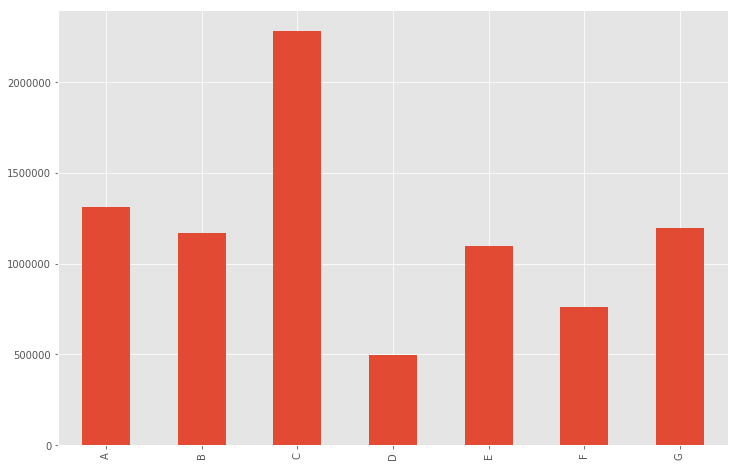

In [18]:
insulation_input.VOORL_BEREKEND.value_counts().reindex(['A', 'B', 'C', 'D', 'E', 'F', 'G']).plot(kind = 'bar')

# 4. Cleaning the data

Checking whether the headers of the sheets are still in the dataset, if yes, we remove them.

In [19]:
insulation_1 = insulation_input[insulation_input.POSTCODE_WONING != 'POSTCODE_WONING']
insulation_1[insulation_1.POSTCODE_WONING == 'POSTCODE_WONING'] 

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND


### Missing data percentage list

In [20]:
for col in insulation_1.columns: # iterate over columns
    p_missing = np.mean(insulation_1[col].isnull()) # returns how many values in columns are NA on average
    print('{} - {}%'.format(col, round(p_missing*100))) # prints in readable format

POSTCODE_WONING - 0.0%
HUISNUMMER_WONING - 0.0%
HUISNUMMER_TOEV_WONING - 83.0%
BOUWJAAR_WONING - 0.0%
WONING_TYPE - 0.0%
VOORL_BEREKEND - 8.0%


No missing values encountered in the entries, only in labels.

### POSTCODE_WONING

Checking if all postcodes are in the same format:

In [21]:
insulation_1.POSTCODE_WONING.str[4:6].str.isalpha().value_counts() # count all entries where the string ends with two letters 

True    9070189
Name: POSTCODE_WONING, dtype: int64

In [22]:
insulation_1.POSTCODE_WONING.str[:4].str.isdigit().value_counts()

True    9070189
Name: POSTCODE_WONING, dtype: int64

All POSTCODE_WONING entries start with 4 digits and end with 2 letters.

### WONING_TYPE

In [23]:
insulation_1.WONING_TYPE.value_counts()

Flat/appartement      2857292
Rijwoning tussen      2027146
Vrijstaande woning    1273558
Twee/één kapwoning     953481
Rijwoning hoek         948928
Niet wonen             942270
Maisonnette             60662
Specifiek object         6852
Name: WONING_TYPE, dtype: int64

We want to exclude the objects that are not intended for living.

In [24]:
insulation_2 = insulation_1[insulation_1.WONING_TYPE != 'Niet wonen']

In [25]:
insulation_2.WONING_TYPE.value_counts()

Flat/appartement      2857292
Rijwoning tussen      2027146
Vrijstaande woning    1273558
Twee/één kapwoning     953481
Rijwoning hoek         948928
Maisonnette             60662
Specifiek object         6852
Name: WONING_TYPE, dtype: int64

### BOUWJAAR_WONING

In [26]:
insulation_2.BOUWJAAR_WONING.dtypes

dtype('O')

In [27]:
# column to numeric
insulation_2['BOUWJAAR_WONING_fl'] = insulation_2.BOUWJAAR_WONING.apply(pd.to_numeric, errors = 'ignore')

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Checking for outliers in the building years:

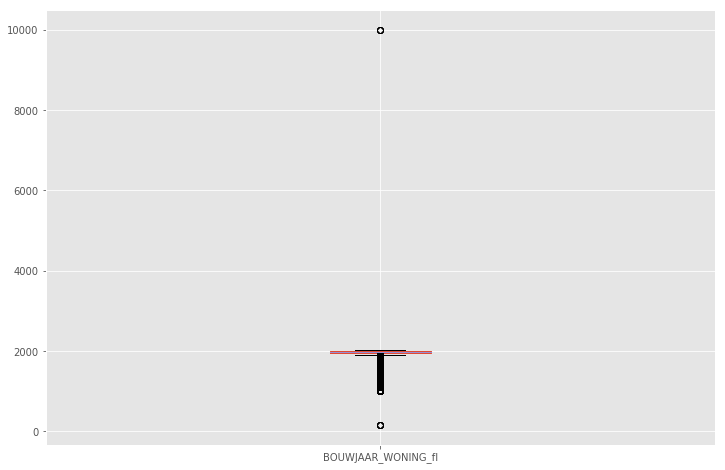

In [28]:
insulation_2.boxplot(column = 'BOUWJAAR_WONING_fl')

There seem to be outliers around 10,000. Lets inspect these:

In [29]:
insulation_2[insulation_2.BOUWJAAR_WONING_fl > 2021]

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND,BOUWJAAR_WONING_fl
7440412,4891AC,10.0,NaN,9999.0,Twee/één kapwoning,A,9999.0
7441314,4891PE,9.0,BUN1,9999.0,Vrijstaande woning,A,9999.0
8368860,7991AS,12.0,NaN,9999.0,Rijwoning tussen,A,9999.0
8373087,7991AK,4.0,NaN,9999.0,Vrijstaande woning,A,9999.0


As there are just a few cases where the building year exceeds the current date, we choose to exclude them from the dataset. Then we inspect again with a boxplot.

In [30]:
insulation_3 = insulation_2[insulation_2.BOUWJAAR_WONING_fl < 2021]

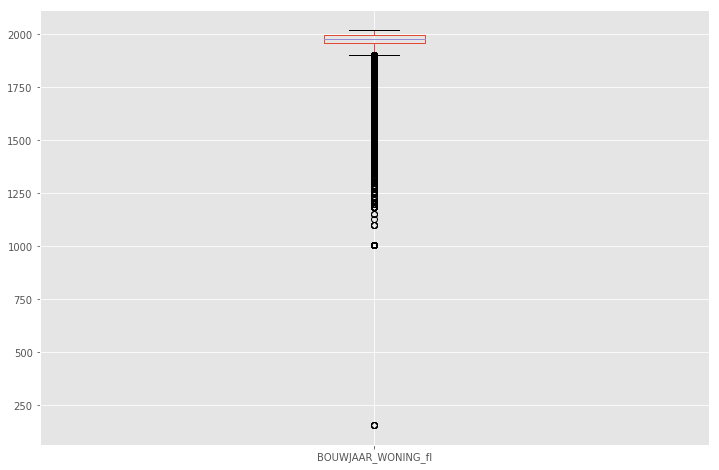

In [31]:
insulation_3.boxplot(column = 'BOUWJAAR_WONING_fl')

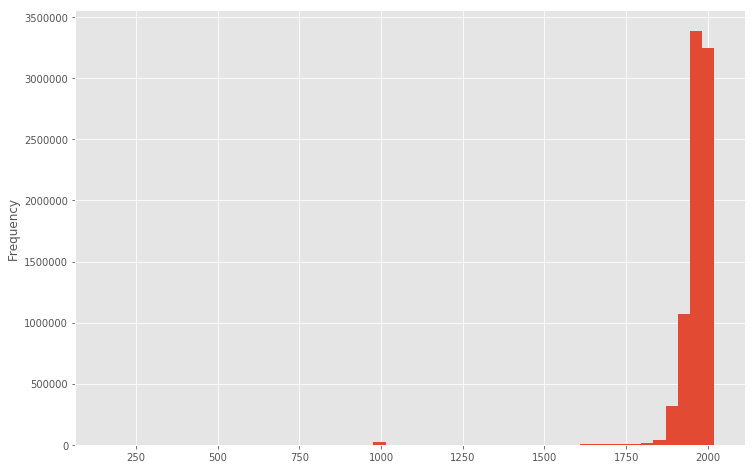

In [32]:
insulation_3.BOUWJAAR_WONING_fl.plot.hist(bins=50)

We see that most of the houses are built from the late 1900's onward, which is plausible. But we still have a few cases around the year 1000. Lets inspect these further:

In [33]:
pd.options.display.max_rows = 50
insulation_3[insulation_3.BOUWJAAR_WONING_fl < 1200]

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND,BOUWJAAR_WONING_fl
5374,9901TP,12.0,NaN,1150.0,Vrijstaande woning,G,1150.0
28912,9905RL,1.0,NaN,1100.0,Vrijstaande woning,G,1100.0
149499,9861AS,6.0,NaN,1100.0,Vrijstaande woning,G,1100.0
900136,7411KS,8.0,NaN,1130.0,Rijwoning tussen,F,1130.0
2526328,3525XL,34.0,1,157.0,Flat/appartement,G,157.0
...,...,...,...,...,...,...,...
8811953,6166EK,8.0,X,1183.0,Flat/appartement,G,1183.0
8811954,6166EK,8.0,XI,1183.0,Flat/appartement,G,1183.0
8811955,6166EK,8.0,XII,1183.0,Flat/appartement,G,1183.0
8811956,6166EK,8.0,XIII,1183.0,Flat/appartement,G,1183.0


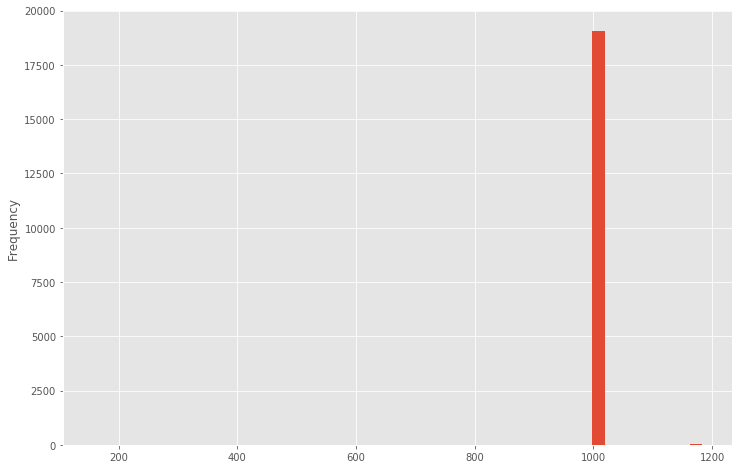

In [34]:
insulation_3.BOUWJAAR_WONING_fl[insulation_3.BOUWJAAR_WONING_fl < 1200].plot.hist(bins=50)

There seems something odd with the dates of year built, but all other information seems to be present.

# 5. Transforming the data

### adding 4 digit postal code column

In [35]:
insulation_3['POSTCODE_DIGITS'] = insulation_3.POSTCODE_WONING.str[:4]
insulation_3

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND,BOUWJAAR_WONING_fl,POSTCODE_DIGITS
0,9901KB,16.0,NaN,2002.0,Flat/appartement,B,2002.0,9901
1,9901KB,20.0,NaN,2002.0,Flat/appartement,B,2002.0,9901
4,9901AD,15.0,NaN,1925.0,Vrijstaande woning,G,1925.0,9901
5,9901AD,6.0,NaN,1950.0,Flat/appartement,E,1950.0,9901
7,9901AD,10.0,A,1930.0,Flat/appartement,G,1930.0,9901
...,...,...,...,...,...,...,...,...
9070192,1601EE,31.0,NaN,2016.0,Rijwoning hoek,A,2016.0,1601
9070193,1601AC,65.0,A,1659.0,Flat/appartement,G,1659.0,1601
9070194,1602CS,20.0,NaN,2017.0,Vrijstaande woning,A,2017.0,1602
9070195,1602CS,24.0,NaN,2017.0,Vrijstaande woning,A,2017.0,1602


### adding low, medium high insulation column

In [36]:
# function that transforms the insulation label to low (1), medium (2) and high (3)

def labeltrans(row):
    if row['VOORL_BEREKEND'] == "G" or row['VOORL_BEREKEND'] == "F" or row['VOORL_BEREKEND'] == "E":
        return 1
    if row['VOORL_BEREKEND'] == "D" or row['VOORL_BEREKEND'] == "C" or row['VOORL_BEREKEND'] == "B":
        return 2
    if row['VOORL_BEREKEND'] == "A" or row['VOORL_BEREKEND'] == "A+" or row['VOORL_BEREKEND'] == "A++":
        return 3
    return 'Other'
    

In [37]:
# function that transforms the insulation label to low (1), medium (2) and high (3)

def labeltrans1(row):
    if row['VOORL_BEREKEND'] == "G":
        return 0
    if row['VOORL_BEREKEND'] == "F":
        return 1
    if row['VOORL_BEREKEND'] == "E":
        return 2
    if row['VOORL_BEREKEND'] == "D":
        return 3
    if row['VOORL_BEREKEND'] == "C":
        return 4
    if row['VOORL_BEREKEND'] == "B":
        return 5
    if row['VOORL_BEREKEND'] == "A":
        return 6
    if row['VOORL_BEREKEND'] == "A+":
        return 7
    if row['VOORL_BEREKEND'] == "A++":
        return 8
    return 'Other'
    

In [38]:
# applying the function and creating a new column 
insulation_3['LABELCAT'] = insulation_3.apply(lambda row: labeltrans1(row), axis=1)

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
insulation_3

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND,BOUWJAAR_WONING_fl,POSTCODE_DIGITS,LABELCAT
0,9901KB,16.0,NaN,2002.0,Flat/appartement,B,2002.0,9901,5
1,9901KB,20.0,NaN,2002.0,Flat/appartement,B,2002.0,9901,5
4,9901AD,15.0,NaN,1925.0,Vrijstaande woning,G,1925.0,9901,0
5,9901AD,6.0,NaN,1950.0,Flat/appartement,E,1950.0,9901,2
7,9901AD,10.0,A,1930.0,Flat/appartement,G,1930.0,9901,0
...,...,...,...,...,...,...,...,...,...
9070192,1601EE,31.0,NaN,2016.0,Rijwoning hoek,A,2016.0,1601,6
9070193,1601AC,65.0,A,1659.0,Flat/appartement,G,1659.0,1601,0
9070194,1602CS,20.0,NaN,2017.0,Vrijstaande woning,A,2017.0,1602,6
9070195,1602CS,24.0,NaN,2017.0,Vrijstaande woning,A,2017.0,1602,6


In [40]:
# check the results of the operation
insulation_3.LABELCAT.value_counts()

4        2243496
0        1197749
5        1169030
6        1158664
2        1096641
1         762379
3         494185
Other       5467
Name: LABELCAT, dtype: int64

In [41]:
# check the 'other' results
# seems like there are missing values in the VOORL_BEREKEND insulation labels

insulation_3[insulation_3.LABELCAT == 'Other']

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND,BOUWJAAR_WONING_fl,POSTCODE_DIGITS,LABELCAT
13758,9697NP,104.0,NaN,1934.0,Specifiek object,NaN,1934.0,9697,Other
15708,9699TT,7.0,NaN,1937.0,Specifiek object,NaN,1937.0,9699,Other
16092,9698AB,39.0,NaN,1990.0,Specifiek object,NaN,1990.0,9698,Other
34372,9725JS,67.0,NaN,1912.0,Specifiek object,NaN,1912.0,9725,Other
56364,9711KT,20.0,NaN,1850.0,Specifiek object,NaN,1850.0,9711,Other
...,...,...,...,...,...,...,...,...,...
9035849,3202JN,12.0,NaN,1962.0,Specifiek object,NaN,1962.0,3202,Other
9039816,1404HH,12.0,C,1891.0,Specifiek object,NaN,1891.0,1404,Other
9040192,1404EL,35.0,A,1920.0,Specifiek object,NaN,1920.0,1404,Other
9043310,9076BZ,118.0,NaN,1931.0,Specifiek object,NaN,1931.0,9076,Other


In [42]:
# If there are no labels, we will drop the entries because they are not of use
# we are trying to make an estimation and not an accurate prediction per household

insulation_4 = insulation_3[insulation_3.LABELCAT != 'Other']

In [43]:
# checking whether the column entries are integers or floats that can be calculated with 
insulation_4.LABELCAT.dtypes

dtype('O')

In [44]:
# apperantly not, so we must change the column to integers
insulation_4['LABELCAT'] = insulation_4.LABELCAT.apply(pd.to_numeric, errors = 'ignore')

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
insulation_4.LABELCAT.dtypes

dtype('int64')

In [46]:
insulation_4.LABELCAT[insulation_4['POSTCODE_DIGITS'] == '3054'].mean()

3.0002421307506055

In [47]:
# output dataframe with 4digits, avg insulation, avg built year

insulation_output = pd.DataFrame({'POSTCODE_DIGITS': insulation_4.POSTCODE_DIGITS.unique()})

In [48]:
#insulation_output['AVG_LABEL'] = insulation_4.groupby('POSTCODE_DIGITS')['LABELCAT'].agg(lambda x: x.uniqueb().mean())
# insulation_output

In [63]:
def woningtype_trans(row, woningtype):
    if row['WONING_TYPE'] == woningtype:
        return 1
    else:
        return 0

In [68]:
woningtypes = insulation_4.WONING_TYPE.unique()
woningtypes



array(['Flat/appartement', 'Vrijstaande woning', 'Rijwoning hoek',
       'Rijwoning tussen', 'Twee/één kapwoning', 'Maisonnette',
       'Specifiek object'], dtype=object)

In [70]:
# create unique postcode_digits df with percentages of building types in columns

# what unique building type entries do we have?
woningtypes = insulation_4.WONING_TYPE.unique()

# these values should be new columns in insulation df and be set to 0

insulation_4[woningtypes[0]].loc[:] = 0
insulation_4[woningtypes[1]].loc[:] = 0
insulation_4[woningtypes[2]].loc[:] = 0
insulation_4[woningtypes[3]].loc[:] = 0
insulation_4[woningtypes[4]].loc[:] = 0
insulation_4

# add 1 to these rows if WONING_TYPE is corresponding with column name

insulation_4[woningtypes[0]] = insulation_4.apply(lambda row: woningtype_trans(row, woningtypes[0]), axis=1)
insulation_4[woningtypes[1]] = insulation_4.apply(lambda row: woningtype_trans(row, woningtypes[1]), axis=1)
insulation_4[woningtypes[2]] = insulation_4.apply(lambda row: woningtype_trans(row, woningtypes[2]), axis=1)
insulation_4[woningtypes[3]] = insulation_4.apply(lambda row: woningtype_trans(row, woningtypes[3]), axis=1)
insulation_4[woningtypes[4]] = insulation_4.apply(lambda row: woningtype_trans(row, woningtypes[4]), axis=1)
insulation_4



/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,POSTCODE_WONING,HUISNUMMER_WONING,HUISNUMMER_TOEV_WONING,BOUWJAAR_WONING,WONING_TYPE,VOORL_BEREKEND,BOUWJAAR_WONING_fl,POSTCODE_DIGITS,LABELCAT,Flat/appartement,Vrijstaande woning,Rijwoning hoek,Rijwoning tussen,Twee/één kapwoning
0,9901KB,16.0,NaN,2002.0,Flat/appartement,B,2002.0,9901,5,1,0,0,0,0
1,9901KB,20.0,NaN,2002.0,Flat/appartement,B,2002.0,9901,5,1,0,0,0,0
4,9901AD,15.0,NaN,1925.0,Vrijstaande woning,G,1925.0,9901,0,0,1,0,0,0
5,9901AD,6.0,NaN,1950.0,Flat/appartement,E,1950.0,9901,2,1,0,0,0,0
7,9901AD,10.0,A,1930.0,Flat/appartement,G,1930.0,9901,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9070192,1601EE,31.0,NaN,2016.0,Rijwoning hoek,A,2016.0,1601,6,0,0,1,0,0
9070193,1601AC,65.0,A,1659.0,Flat/appartement,G,1659.0,1601,0,1,0,0,0,0
9070194,1602CS,20.0,NaN,2017.0,Vrijstaande woning,A,2017.0,1602,6,0,1,0,0,0
9070195,1602CS,24.0,NaN,2017.0,Vrijstaande woning,A,2017.0,1602,6,0,1,0,0,0


In [88]:
# new output dfs with groupby postcode_digits and mean of colun woningtypes 

insulation_woningtype_output = insulation_4.groupby('POSTCODE_DIGITS')[woningtypes[:5]].mean()
insulation_woningtype_output['sumcolumn'] = insulation_woningtype_output.sum(axis=1)
insulation_woningtype_output

,Flat/appartement,Vrijstaande woning,Rijwoning hoek,Rijwoning tussen,Twee/één kapwoning,sumcolumn
POSTCODE_DIGITS,,,,,,
1011,0.967523,0.000315,0.002365,0.029324,0.000000,0.999527
1012,0.945481,0.000000,0.002292,0.052227,0.000000,1.000000
1013,0.984721,0.000792,0.001108,0.012825,0.000554,1.000000
1014,0.916449,0.003481,0.010444,0.067885,0.001741,1.000000
1015,0.946943,0.000100,0.002892,0.049865,0.000199,1.000000
...,...,...,...,...,...,...
9995,0.033898,0.627119,0.088136,0.105085,0.145763,1.000000
9996,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
9997,0.000000,0.698113,0.064151,0.086792,0.150943,1.000000


In [117]:
insulation_output = insulation_4.groupby('POSTCODE_DIGITS')['LABELCAT', 'BOUWJAAR_WONING_fl'].mean()
insulation_output_merged = insulation_output.merge(insulation_woningtype_output, how = "inner", left_index=True, right_index=True )
insulation_output_merged

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,LABELCAT,BOUWJAAR_WONING_fl,Flat/appartement,Vrijstaande woning,Rijwoning hoek,Rijwoning tussen,Twee/één kapwoning,sumcolumn
POSTCODE_DIGITS,,,,,,,,
1011,1.854643,1708.197383,0.967523,0.000315,0.002365,0.029324,0.000000,0.999527
1012,0.804682,1400.158481,0.945481,0.000000,0.002292,0.052227,0.000000,1.000000
1013,2.161890,1846.434927,0.984721,0.000792,0.001108,0.012825,0.000554,1.000000
1014,5.661880,2012.497389,0.916449,0.003481,0.010444,0.067885,0.001741,1.000000
1015,1.096539,1572.592700,0.946943,0.000100,0.002892,0.049865,0.000199,1.000000
...,...,...,...,...,...,...,...,...
9995,1.810169,1940.305085,0.033898,0.627119,0.088136,0.105085,0.145763,1.000000
9996,0.787879,1917.515152,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
9997,1.509434,1933.241509,0.000000,0.698113,0.064151,0.086792,0.150943,1.000000


In [118]:
# renaming columns to prevent issues with geopandas

insulation_output_merged = insulation_output_merged.rename(columns={'Flat/appartement': 'FLAT_APP', 'Vrijstaande woning':'VRIJ','Rijwoning hoek':'RIJHOEK','Rijwoning tussen':'RIJTUSSEN','Twee/één kapwoning':'TWEE_KAP'})
insulation_output_merged

,LABELCAT,BOUWJAAR_WONING_fl,FLAT_APP,VRIJ,RIJHOEK,RIJTUSSEN,TWEE_KAP,sumcolumn
POSTCODE_DIGITS,,,,,,,,
1011,1.854643,1708.197383,0.967523,0.000315,0.002365,0.029324,0.000000,0.999527
1012,0.804682,1400.158481,0.945481,0.000000,0.002292,0.052227,0.000000,1.000000
1013,2.161890,1846.434927,0.984721,0.000792,0.001108,0.012825,0.000554,1.000000
1014,5.661880,2012.497389,0.916449,0.003481,0.010444,0.067885,0.001741,1.000000
1015,1.096539,1572.592700,0.946943,0.000100,0.002892,0.049865,0.000199,1.000000
...,...,...,...,...,...,...,...,...
9995,1.810169,1940.305085,0.033898,0.627119,0.088136,0.105085,0.145763,1.000000
9996,0.787879,1917.515152,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
9997,1.509434,1933.241509,0.000000,0.698113,0.064151,0.086792,0.150943,1.000000


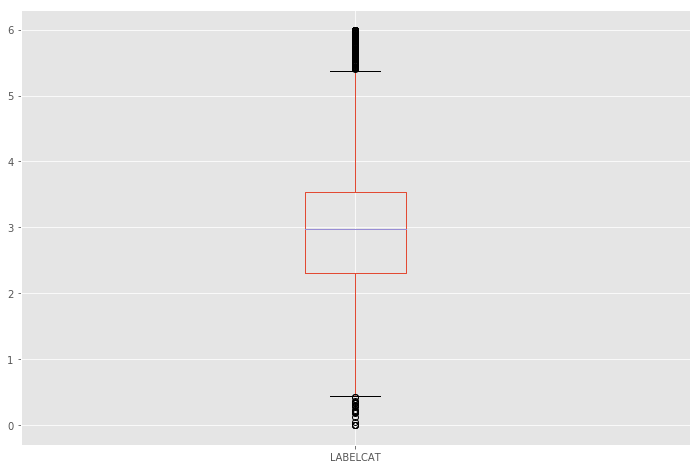

In [119]:
insulation_output.boxplot(column = 'LABELCAT')

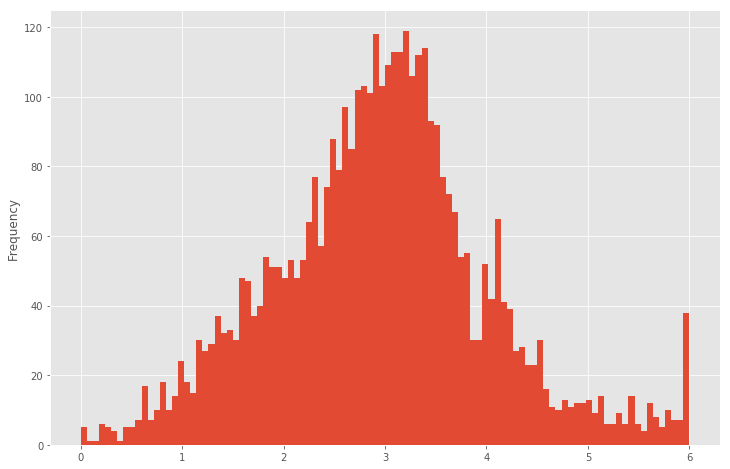

In [120]:
# plotting distribution of avg label categories
insulation_output.LABELCAT.plot.hist(bins=100)

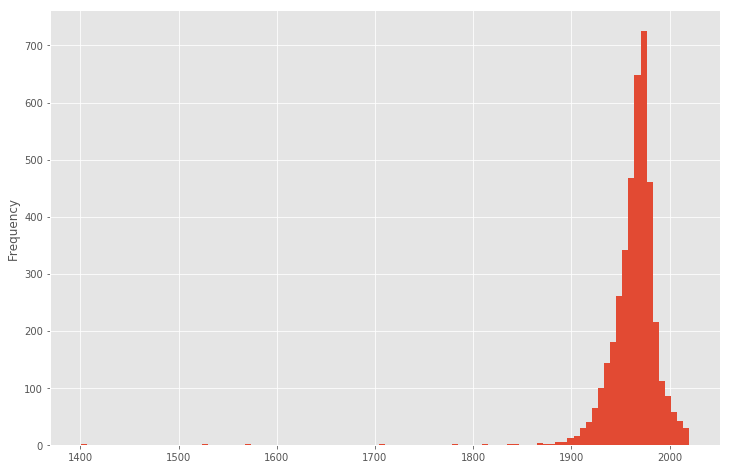

In [121]:
# plotting distribution of avg building year
insulation_output.BOUWJAAR_WONING_fl.plot.hist(bins=100)

In [122]:
insulation_output.LABELCAT.mean()

2.960321430707261

In [123]:
for col in insulation_output.columns: # iterate over columns
    p_missing = np.mean(insulation_output[col].isnull()) # returns how many values in columns are NA on average
    print('{} - {}%'.format(col, round(p_missing*100))) # prints in readable format

LABELCAT - 0.0%
BOUWJAAR_WONING_fl - 0.0%


# 6. Writing the data

In [124]:
insulation_output_merged.to_csv('/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Output/postcode_ins_by_woningcat_v1.csv')